# E-prop training of dope RNN on hold task

Here we explore training the weights via BPTT

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from disp import set_plot

print('Torch version:', torch.__version__)
print('Cuda available:', torch.cuda.is_available())

device = 'cuda' if  torch.cuda.is_available() else 'cpu'
print('Device:', device)  # tested on cpu and cuda

Torch version: 1.7.1
Cuda available: False
Device: cpu


First we discretize the continuous dynamical system

$$\tau \frac{d\mathbf{x}}{dt} = -\mathbf{x} + \mathbf{f}_{base}(\mathbf{x}) + CW^T\psi(\mathbf{x})$$

where $\psi(\mathbf{x}) = \tanh(J_\psi \mathbf{x})$ and $(J_\psi)_{id} \sim \mathcal{N}(0, g)$, to

$$\mathbf{x}^t = \mathbf{x}^{t-1} + \frac{\Delta t}{\tau} \left( -\mathbf{x}^{t-1} + \mathbf{f}_{base}(\mathbf{x}^{t-1}) + CW^T\psi(\mathbf{x}^{t-1})\right).$$

For now we leave $\mathbf{f}_{base} = 0$ so that

$$\mathbf{x}^t = \mathbf{x}^{t-1} + \frac{\Delta t}{\tau} \left( -\mathbf{x}^{t-1} + CW^T\psi(\mathbf{x}^{t-1})\right).$$

## 1-dimensional

In [2]:
# model params
D = 1
N = 2000
TAU = .01
G = 100

DT = .001

J_psi = G*torch.randn((N, D), device=device)
C = torch.eye(D, device=device)

# smln params
x_0s = [torch.tensor([1.], device=device), torch.tensor([-1.], device=device)]

def advance(x, z, w_T):
    psi = (1 + torch.tanh(J_psi@z))/2*np.sqrt(2/N)
    return x + DT/TAU*(-x + C@w_T@psi)

def get_z(x):
    return 1*x

targs = [torch.tensor([1.], device=device), torch.tensor([-1.], device=device)]

def loss_fn(z_hats, targ):
    return torch.mean((z_hats[-1, :] - targ)**2)

## E-prop factorization of the loss gradient

$$\frac{dE}{dW_{ij}} = \sum_t \frac{dE}{d\hat{z}_i^t} \left[ \frac{\partial \hat{z}_i^t}{\partial W_{ij}} \right]_{local} = \sum_t \frac{dE}{d\hat{z}_i^t} e_{ij}^t$$

where

$$
e_{ij}^t = \left[ \frac{\partial \hat{z}_i^t}{\partial W_{ij}} \right]_{local} = \frac{\partial \hat{z}_i^t}{\partial \hat{x}_i^t} \sum_{t' \leq t}\frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \dots \frac{\partial \hat{x}_i^{t'+1}}{\partial \hat{x}_i^{t'}}
\frac{\partial \hat{x}_i^{t'}}{\partial W_{ij}}
$$


Or, in vector format (note that $\frac{dE}{d\mathbf{w}_i}$, $\mathbf{e}_i^t$, and $\boldsymbol{\epsilon}_i^t$ are all row vectors):

$$\frac{dE}{d\mathbf{w}_i} = \sum_t \frac{dE}{d\hat{z}_i^t} \left[ \frac{\partial \hat{z}_i^t}{\partial \mathbf{w}_i} \right]_{local} = \sum_t \frac{dE}{d\hat{z}_i^t} \mathbf{e}_i^t = \sum_t L_i^t \mathbf{e}_i^t$$

where

$$
\mathbf{e}_i^t = \left[ \frac{\partial \hat{z}_i^t}{\partial \mathbf{w}_i} \right]_{local} = \frac{\partial \hat{z}_i^t}{\partial \hat{x}_i^t} \sum_{t' \leq t}\frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \dots \frac{\partial \hat{x}_i^{t'+1}}{\partial \hat{x}_i^{t'}}
\frac{\partial \hat{x}_i^{t'}}{\partial \mathbf{w}_i}
= \frac{\partial \hat{z}_i^t}{\partial \hat{x}_i^t} \boldsymbol{\epsilon}_i^t
$$

with

$$
\boldsymbol{\epsilon}_i^t \equiv \sum_{t' \leq t}\frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \dots \frac{\partial \hat{x}_i^{t'+1}}{\partial \hat{x}_i^{t'}}
\frac{\partial \hat{x}_i^{t'}}{\partial \mathbf{w}_i}
$$

which can also be computed recursively:

$$
\boldsymbol{\epsilon}_i^1 = \frac{\partial \hat{x}_i^1}{\partial \mathbf{w}_i} \quad \quad \quad
\boldsymbol{\epsilon}_i^t = \frac{\partial \hat{x}_i^t}{\partial \hat{x}_i^{t-1}} \boldsymbol{\epsilon}_i^{t-1} + \frac{\partial \hat{x}_i^t}{\partial \mathbf{w}_i}
$$

## E-prop

We first study the ideal case (above), in which the factorization should reproduce the full BPTT gradient exactly. Set use_approx to True to see
approx e-prop (where learning signal is replaced with partial derivative).

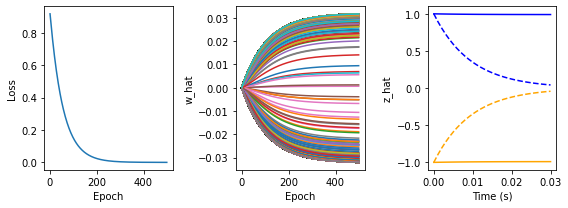

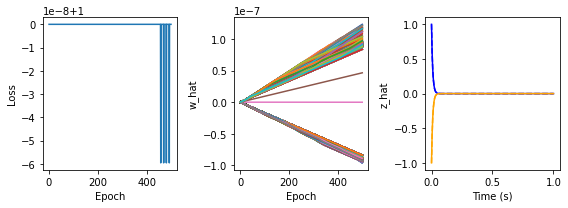

In [3]:
lr = 0.01
nepoch = 500
use_approx = False
# use_approx = True

TS = [.03, 1.]

losses_all = []

for T in TS:
    
    IT = int(round(T/DT))
    t = np.arange(0, IT+1, dtype=float)*DT

    w_T_hat = (0.*torch.ones((D, N), device=device)).detach()
    w_T_hat.requires_grad = True

    w_T_hat_flats = np.nan*np.ones((nepoch, D*N))

    z_hats_initial = []

    losses = []

    for epoch in range(nepoch):
        # compute first terms (dE/dx_t) using autograd
        x_hats_0 = [x_0s[0].clone()]
        z_hats_0 = [get_z(x_hats_0[0])]

        for ct in range(1, IT+1):
            x_hat_0 = advance(x_hats_0[ct-1], z_hats_0[ct-1], w_T_hat)
            x_hat_0.retain_grad()

            z_hat_0 = get_z(x_hat_0)
            z_hat_0.retain_grad()

            x_hats_0.append(x_hat_0)
            z_hats_0.append(z_hat_0)

        x_hats_stack_0 = torch.stack(x_hats_0)
        z_hats_stack_0 = torch.stack(z_hats_0)
        z_hats_stack_0.retain_grad()

        loss_0 = loss_fn(z_hats_stack_0, targs[0])

        ### second initial condition
        x_hats_1 = [x_0s[1].clone()]
        z_hats_1 = [get_z(x_hats_1[0])]

        for ct in range(1, IT+1):
            x_hat_1 = advance(x_hats_1[ct-1], z_hats_1[ct-1], w_T_hat)
            x_hat_1.retain_grad()

            z_hat_1 = get_z(x_hat_1)
            z_hat_1.retain_grad()

            x_hats_1.append(x_hat_1)
            z_hats_1.append(z_hat_1)

        x_hats_stack_1 = torch.stack(x_hats_1)
        z_hats_stack_1 = torch.stack(z_hats_1)
        z_hats_stack_1.retain_grad()

        loss_1 = loss_fn(z_hats_stack_1, targs[1])

        loss = .5*(loss_0 + loss_1)
        loss.backward(retain_graph=True)

        # get learning signals (x_hats grad)
        Ls_0 = [z_hat_0.grad for z_hat_0 in z_hats_0]
        Ls_1 = [z_hat_1.grad for z_hat_1 in z_hats_1]
        Ls_approx_0 = [grad for grad in z_hats_stack_0.grad]
        Ls_approx_1 = [grad for grad in z_hats_stack_1.grad]

        w_T_hat.grad.zero_()

        ## get eligibility vectors
        evs_0 = torch.zeros((IT+1, D, N), device=device)  # each row is an e-vector

        for ct in range(1, IT+1):
            partial_x_hat_0, partial_z_hat_0, partial_w_T_hat_0 = torch.autograd.functional.jacobian(advance, inputs=(x_hats_0[ct-1], z_hats_0[ct-1], w_T_hat))
            # loop over neurons
            for i in range(D):
                evs_0[ct, i, :] = partial_x_hat_0[i, i]*evs_0[ct-1, i, :] + partial_w_T_hat_0[i][i, :]

        # convert to eligibility traces
        ets_0 = 1*evs_0  # special case for identity activation function

        # compute gradient
        e_prop_grad_0 = torch.zeros((D, N), device=device)
        e_prop_grad_approx_0 = torch.zeros((D, N), device=device)
        for ct in range(1, IT+1):
            e_prop_grad_0 += Ls_0[ct][:, None]*ets_0[ct, i, :]
            e_prop_grad_approx_0 += Ls_approx_0[ct][:, None]*ets_0[ct, i, :]

        evs_1 = torch.zeros((IT+1, D, N), device=device)  # each row is an e-vector

        for ct in range(1, IT+1):
            partial_x_hat_1, partial_z_hat_1, partial_w_T_hat_1 = torch.autograd.functional.jacobian(advance, inputs=(x_hats_1[ct-1], z_hats_1[ct-1], w_T_hat))
            # loop over neurons
            for i in range(D):
                evs_1[ct, i, :] = partial_x_hat_1[i, i]*evs_1[ct-1, i, :] + partial_w_T_hat_1[i][i, :]

        # convert to eligibility traces
        ets_1 = 1*evs_1  # special case for identity activation function

        # compute gradient
        e_prop_grad_1 = torch.zeros((D, N), device=device)
        e_prop_grad_approx_1 = torch.zeros((D, N), device=device)
        for ct in range(1, IT+1):
            e_prop_grad_1 += Ls_1[ct][:, None]*ets_1[ct, i, :]
            e_prop_grad_approx_1 += Ls_approx_1[ct][:, None]*ets_1[ct, i, :]

        e_prop_grad = e_prop_grad_0 + e_prop_grad_1
        e_prop_grad_approx = e_prop_grad_approx_0 + e_prop_grad_approx_1

        with torch.no_grad():
            if use_approx:
                w_T_hat -= lr*e_prop_grad_approx
            else:
                w_T_hat -= lr*e_prop_grad

        losses.append(loss.item())
        w_T_hat_flats[epoch, :] = w_T_hat.detach().cpu().numpy().flatten()

        if epoch == 0:
            z_hats_initial.append(z_hats_stack_0.detach().cpu().numpy())
            z_hats_initial.append(z_hats_stack_1.detach().cpu().numpy())

    losses_all.append(losses)
    
    fig, axs = plt.subplots(1, 3, figsize=(8, 3), tight_layout=True)
    axs[0].plot(losses)
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')

    axs[1].plot(w_T_hat_flats)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('w_hat')

    axs[2].plot(t, z_hats_initial[0], c='b', ls='--')
    axs[2].plot(t, z_hats_initial[1], c='orange', ls='--')
    axs[2].plot(t, z_hats_stack_0.detach().cpu().numpy(), c='b', ls='-')
    axs[2].plot(t, z_hats_stack_1.detach().cpu().numpy(), c='orange', ls='-')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('z_hat')

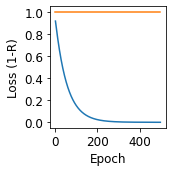

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), tight_layout=True)
for losses in losses_all:
    ax.plot(losses)
set_plot(ax, x_label='Epoch', y_label='Loss (1-R)')

if use_approx == False:
    fig.savefig('ms/5_hold_loss_eprop.svg')
else:
    fig.savefig('ms/5_hold_loss_eprop_approx.svg')